In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/TFM2021/cmodels')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# TASK 1 : Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import  os
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, auc 
import seaborn as sns
import CNN_models  
import Helpers

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = 250
BATCH_SIZE = 128 # 32 -> good


# TASK 2 : Clone & Explore dataset

In [4]:
#clone the dataset from the github repository
! git clone https://github.com/srobayo-gts/pictures.git

Cloning into 'pictures'...
remote: Enumerating objects: 23710, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 23710 (delta 1), reused 6 (delta 1), pack-reused 23704
Receiving objects: 100% (23710/23710), 1.45 GiB | 27.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (23757/23757), done.


In [5]:
#set the path to the main dir
import os
main_dir = "/content/pictures/data"

#set the path to the covid images dir
covid_img_dir = os.path.join(main_dir, "covid")

#set the path to the normal images dir
normal_img_dir = os.path.join(main_dir, "normal")


In [6]:
#print the filenames
covid_file_names = tf.io.gfile.glob(str(main_dir + '/covid/*'))
print(covid_file_names[:10])

normal_file_names = tf.io.gfile.glob(str(main_dir + '/normal/*'))
print(normal_file_names[:10])


['/content/pictures/data/covid/covid-1351.png', '/content/pictures/data/covid/covid-2960.png', '/content/pictures/data/covid/covid-4654.png', '/content/pictures/data/covid/covid-3536.png', '/content/pictures/data/covid/covid-767.png', '/content/pictures/data/covid/covid-3019.png', '/content/pictures/data/covid/covid-2069.png', '/content/pictures/data/covid/covid-2575.png', '/content/pictures/data/covid/covid-4038.png', '/content/pictures/data/covid/covid-2369.png']
['/content/pictures/data/normal/normal-14945.png', '/content/pictures/data/normal/normal-16951.png', '/content/pictures/data/normal/normal-9075.png', '/content/pictures/data/normal/normal-14136.png', '/content/pictures/data/normal/normal-18949.png', '/content/pictures/data/normal/normal-14227.png', '/content/pictures/data/normal/normal-14779.png', '/content/pictures/data/normal/normal-7384.png', '/content/pictures/data/normal/normal-65.png', '/content/pictures/data/normal/normal-6603.png']


In [7]:
#print the total no of images present in each dir
print("total images present in covid folder :", len(covid_file_names))
print("total images present in normal folder :", len(normal_file_names))

total images present in covid folder : 4712
total images present in normal folder : 19043


# TASK 3 : Data Visualization

['/content/pictures/data/covid/covid-1351.png', '/content/pictures/data/covid/covid-2960.png', '/content/pictures/data/covid/covid-4654.png', '/content/pictures/data/covid/covid-3536.png', '/content/pictures/data/covid/covid-767.png', '/content/pictures/data/covid/covid-3019.png', '/content/pictures/data/covid/covid-2069.png', '/content/pictures/data/covid/covid-2575.png']
['/content/pictures/data/normal/normal-14945.png', '/content/pictures/data/normal/normal-16951.png', '/content/pictures/data/normal/normal-9075.png', '/content/pictures/data/normal/normal-14136.png', '/content/pictures/data/normal/normal-18949.png', '/content/pictures/data/normal/normal-14227.png', '/content/pictures/data/normal/normal-14779.png', '/content/pictures/data/normal/normal-7384.png']


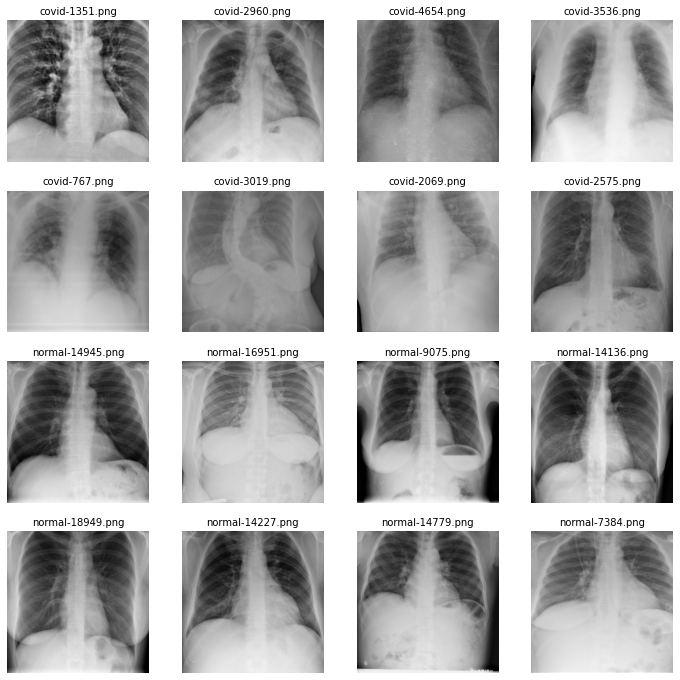

In [8]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 4
#set the figure size
fig = plt.gcf()
fig.set_size_inches(12, 12)
#get the filenames from the covid & normal dir of the train dataset
covid_pic = [os.path.join(covid_img_dir, filename)for filename in covid_file_names[0:8]]
normal_pic = [os.path.join(normal_img_dir, filename)for filename in normal_file_names[0:8]]

#print the list
print(covid_pic)
print(normal_pic)
#merge the covid and normal list
merget_list = covid_pic+normal_pic

for i, img_path in enumerate(merget_list):
  data = img_path.split('/', 6)[5]
  sp = plt.subplot(rows,cols,i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=10)
  plt.imshow(img,cmap='gray')
plt.show()  

## TASK 4: Define Train & Test Datasets

In [9]:
random.seed(2000)
tf.random.set_seed(3000)
random.shuffle(normal_file_names)
filenames = normal_file_names[0:6300] # 5300
filenames.extend(covid_file_names)
# total images = 10012

# TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(filenames, test_size=0.25, random_state=5)
# TRAIN_FILENAMES, TEST_FILENAMES = train_test_split(TRAIN_FILENAMES, test_size=0.2, random_state=5)

# 90% -> 60/20/20
# TRAIN_FILENAMES, TEST_FILENAMES = train_test_split(filenames, test_size=0.2, random_state=100)
# TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(TRAIN_FILENAMES, test_size=0.25, random_state=42)

# 91% -> 70/15/15
# TRAIN_FILENAMES, TEST_FILENAMES = train_test_split(filenames, test_size=0.15, random_state=100)
# TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(TRAIN_FILENAMES, test_size=0.177, random_state=42)

# 93-95% -> 80/10/10
TRAIN_FILENAMES, TEST_FILENAMES = train_test_split(filenames, test_size=0.1, random_state=100)
TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(TRAIN_FILENAMES, test_size=0.111, random_state=42)

print(len(TRAIN_FILENAMES))
print(len(VALID_FILENAMES))
print(len(TEST_FILENAMES))

8809
1101
1102


# TASK 5 : Build Convolutional Neural Network Model

In [10]:
def make_model4(image_size):
    input_shape = (image_size, image_size, 3)
    kernel_size = (3,3)
    dropout = 0.5
    pool_size = (2,2)
    strides_size = (1,1)
    inputs = Input(shape=input_shape)

    # CONV1
    conv1 = Conv2D(filters=64, kernel_size=kernel_size,strides = strides_size,padding = 'same', activation='relu')(inputs)
    #conv1 = BatchNormalization()(conv1)
    conv1 = MaxPool2D(pool_size=pool_size)(conv1)

    # CONV2
    conv2 = Conv2D(filters=64, kernel_size=kernel_size,strides = strides_size,padding = 'same',  activation='relu')(conv1)
    #conv2 = BatchNormalization()(conv2)
    pooling1 = MaxPool2D(pool_size=pool_size)(conv2)
    
    # CONV3
    conv3 = Conv2D(filters=64, kernel_size=kernel_size,strides = strides_size,padding = 'same',  activation='relu')(pooling1)
    #conv3 = BatchNormalization()(conv3)
    pooling2 = MaxPool2D(pool_size=pool_size)(conv3)

    # CONV4
    conv4 = Conv2D(filters=128, kernel_size=kernel_size,strides = strides_size, padding = 'same',activation='relu')(pooling2)
    #conv4 = BatchNormalization()(conv4)
    pooling3 = MaxPool2D(pool_size=pool_size)(conv4)

    # CONV5
    conv5 = Conv2D(filters=256, kernel_size=kernel_size,strides = strides_size, padding = 'same', activation='relu')(pooling3)
    #conv5 = BatchNormalization()(conv5)
    pooling4 = MaxPool2D(pool_size=pool_size)(conv5)
    
    # image to vector before connecting to dense layer
    y = Flatten()(pooling4)

    y = Dense(128, activation='relu')(y)
    y = Dropout(dropout)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(dropout)(y)
    outputs = Dense(1, activation='sigmoid')(y)

    # build the model by supplying inputs/outputs
    model = Model(inputs=inputs, outputs= outputs)

    # network model in text
    # model.summary()
    model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
import gc
gc.collect()
model = make_model4(IMAGE_SIZE)
plot_model(model, show_shapes=True, to_file='CNNModel.png')
print(model.summary())
print(1e-3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 250, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0     

## TASK 5 : Create helper functions

(250, 250, 3)
tf.Tensor(True, shape=(), dtype=bool)


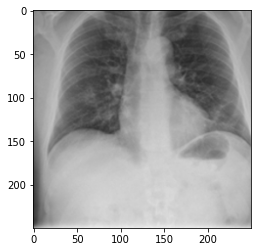

In [12]:

CLASSES = ['normal', 'covid']
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == 'covid' # covid = True(1), normal = False(0)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def process_path_predict(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img
    

# get_label('/content/pictures/data/normal/normal-16435.png') 
img, label = process_path('/content/pictures/data/covid/covid-2446.png')
print(img.shape)
print(label)
plt.imshow(img)  

## TASK 6: Process the images

In [13]:
train_list_ds = tf.data.Dataset.from_tensor_slices(TRAIN_FILENAMES)
val_list_ds = tf.data.Dataset.from_tensor_slices(VALID_FILENAMES)
test_list_ds = tf.data.Dataset.from_tensor_slices(TEST_FILENAMES)
# pred_list_ds = tf.data.Dataset.from_tensor_slices(TEST_FILENAMES)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#pred_ds = pred_list_ds.map(process_path_predict, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(54000)
train_ds = train_ds.batch(BATCH_SIZE)
# train_ds = train_ds.repeat() # When providing an infinite dataset, you must specify the number of steps to run
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = val_ds.shuffle(6000)
val_ds = val_ds.batch(BATCH_SIZE)
# val_ds = val_ds.repeat() # When providing an infinite dataset, you must specify the number of steps to run
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)



In [14]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))



Training images count: 8809
Validating images count: 1101


# TASK 6 : Set Class Weights for handle inbalance data

In [15]:
COUNT_NORMAL_TRAIN = len([filename for filename in TRAIN_FILENAMES if "normal" in filename])
COUNT_COVID_TRAIN = len([filename for filename in TRAIN_FILENAMES if "covid" in filename])
TRAIN_IMG_COUNT = len(TRAIN_FILENAMES)


print('COUNT_NORMAL_TRAIN = ', COUNT_NORMAL_TRAIN)
print('COUNT_COVID_TRAIN = ', COUNT_COVID_TRAIN)
print('TRAIN_IMG_COUNT = ', TRAIN_IMG_COUNT)
print('*******************************************************')


COUNT_NORMAL_TEST = len([filename for filename in TEST_FILENAMES if "normal" in filename])
COUNT_COVID_TEST = len([filename for filename in TEST_FILENAMES if "covid" in filename])
TEST_IMG_COUNT = len(TEST_FILENAMES)

print('COUNT_NORMAL_TEST = ', COUNT_NORMAL_TEST)
print('COUNT_COVID_TEST = ', COUNT_COVID_TEST)
print('TEST_IMG_COUNT = ', TEST_IMG_COUNT)


weight_for_0 = (1 / COUNT_NORMAL_TRAIN)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_COVID_TRAIN)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('*******************************************************')
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


COUNT_NORMAL_TRAIN =  4982
COUNT_COVID_TRAIN =  3827
TRAIN_IMG_COUNT =  8809
*******************************************************
COUNT_NORMAL_TEST =  644
COUNT_COVID_TEST =  458
TEST_IMG_COUNT =  1102
*******************************************************
Weight for class 0: 0.88
Weight for class 1: 1.15


## Set Keras Calbacks

In [ ]:
log = CSVLogger('/content/drive/MyDrive/cnnTraining/logcnn/logcnn.csv', separator=",", append=False)

checkpoint_cb = ModelCheckpoint(filepath='/content/drive/MyDrive/cnnTraining/weights-{epoch:02d}.h5', 
                                          monitor='accuracy', 
                                          save_best_only=True, 
                                          save_weights_only=True,
                                          verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=6)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 6, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [log, checkpoint_cb, early_stopping, learning_rate_reduction]

In [ ]:
historytr = model.fit(train_ds,
                    epochs = 30,
                    validation_data = val_ds,
                    callbacks = callbacks_list,
                    class_weight = class_weight)


Epoch 1/30
69/69 [==============================] - 108s 749ms/step - loss: 0.6603 - accuracy: 0.5760 - val_loss: 0.5633 - val_accuracy: 0.7021

Epoch 00001: accuracy improved from -inf to 0.57600, saving model to /content/drive/MyDrive/cnnTraining/weights-01.h5
Epoch 2/30
69/69 [==============================] - 66s 607ms/step - loss: 0.5361 - accuracy: 0.7305 - val_loss: 0.4765 - val_accuracy: 0.7602

Epoch 00002: accuracy improved from 0.57600 to 0.73050, saving model to /content/drive/MyDrive/cnnTraining/weights-02.h5
Epoch 3/30
69/69 [==============================] - 59s 610ms/step - loss: 0.4613 - accuracy: 0.7883 - val_loss: 0.4026 - val_accuracy: 0.8193

Epoch 00003: accuracy improved from 0.73050 to 0.78828, saving model to /content/drive/MyDrive/cnnTraining/weights-03.h5
Epoch 4/30
69/69 [==============================] - 58s 605ms/step - loss: 0.4088 - accuracy: 0.8151 - val_loss: 0.3816 - val_accuracy: 0.8292

Epoch 00004: accuracy improved from 0.78828 to 0.81508, saving 

## Save Wole History

In [ ]:

# np.save('/content/drive/MyDrive/cnnTraining/historycnn/historycnn.npy',historytr.history)   


## Get History

In [16]:
history=np.load('/content/drive/MyDrive/cnnTraining/historycnn/historycnn.npy',allow_pickle='TRUE').item()

# TASK 7 : Performance Evaluation

In [ ]:
#get the keys of history object
#historytr.history.keys()


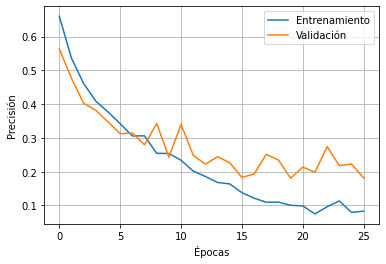

In [19]:
#plot graph between training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])
# plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)

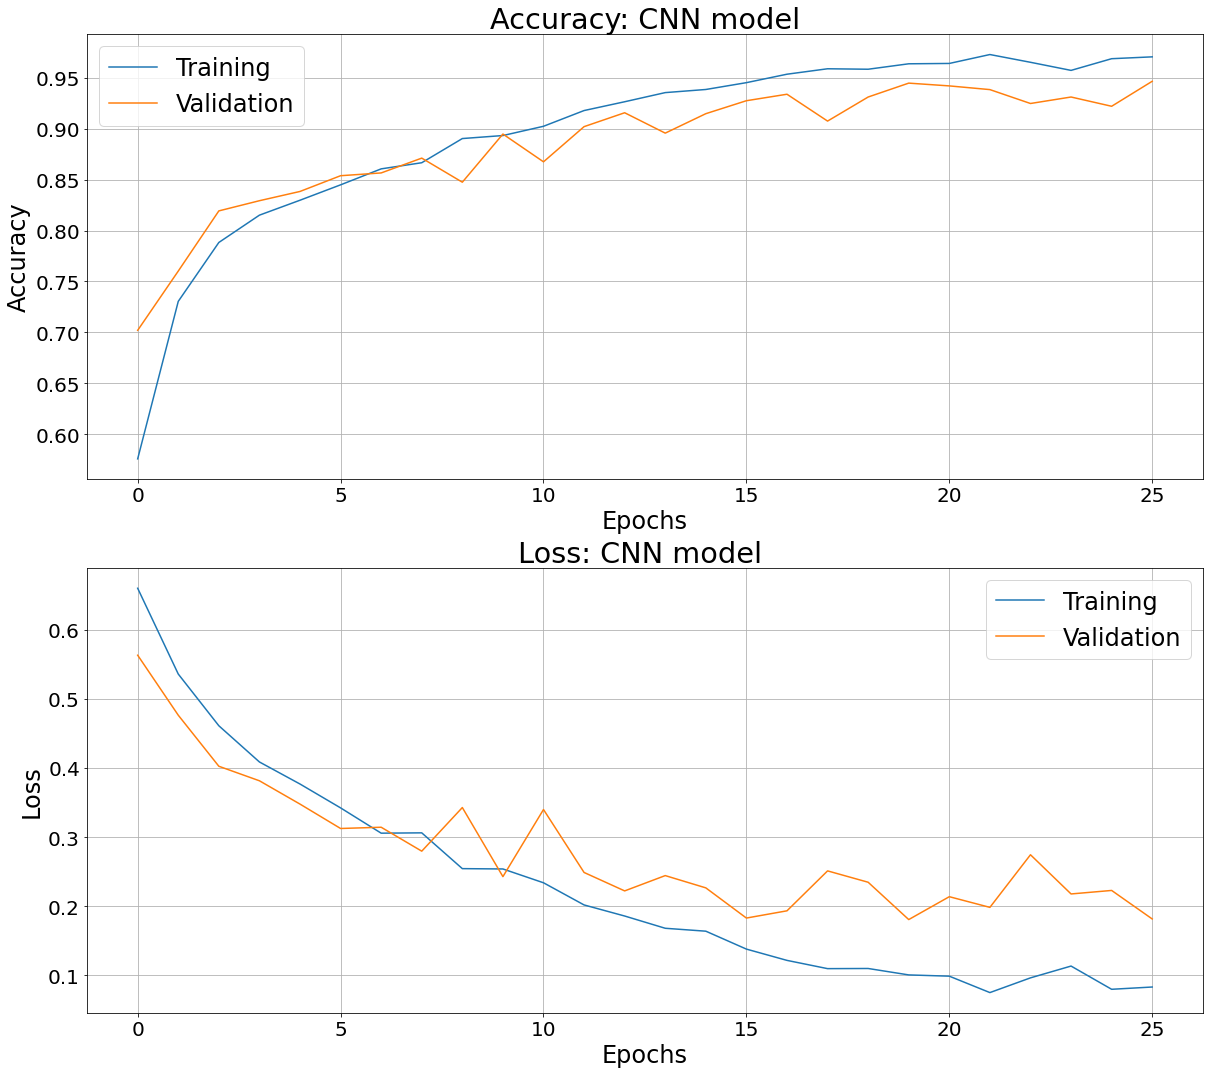

In [30]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 3))
fig, ax = plt.subplots(2, 1, figsize=(20,18))
ax = ax.ravel()
plt.rcParams.update({'font.size': 24})
# spanish

# titles = ['Precisión del modelo CNN', 'Pérdida del modelo CNN']
# ylabels = ['Precisión', 'Pérdida']
# epoch_Label = 'Épocas'
# train_label  = 'Entrenamiento'
# val_label =  'Validación'
# legend_ = ['Entrenamiento', 'Validación']

# english
titles = ['Accuracy: CNN model', 'Loss: CNN model ']
ylabels = ['Accuracy', 'Loss']
epoch_Label = 'Epochs'
legend_ = ['Training', 'Validation']


font_size = 24

# for i, met in enumerate(['accuracy', 'loss']):
#     ax[i].plot(history[met])
#     ax[i].plot(history['val_' + met])
#     # ax[i].set_title('Model {}'.format(met))
#     ax[i].set_title(titles[i], fontsize=font_size)
#     ax[i].set_xlabel(epoch_Label, fontsize=font_size)
#     # ax[i].set_ylabel(met) 
#     ax[i].set_ylabel(ylabels[i], fontsize=font_size)
#     ax[i].legend(legend_,fontsize=font_size)
#     ax[i].grid()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[met])
    ax[i].plot(history['val_' + met])
    # ax[i].set_title('Model {}'.format(met))
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(epoch_Label, fontsize=font_size)
    # ax[i].set_ylabel(met) 
    ax[i].set_ylabel(ylabels[i], fontsize=font_size)
    ax[i].legend(legend_)
    ax[i].grid()    

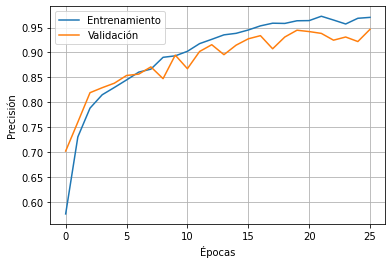

In [ ]:
#plot graph between training and validation accuarcy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['Entrenamiento', 'Validación'])
# plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)

In [ ]:
# get the test acuarcy and loss
# loss, tp, fp, tn, fn, accuracy, precision, recall,auc, sensitivity = model.evaluate(test_ds)
# print('test loss :{} test acc :{}'.format(loss, accuracy))
loss,  accuracy = model.evaluate(test_ds)
print('test loss :{} test acc :{}'.format(loss, accuracy))

## Load weights

In [23]:
model.load_weights("/content/drive/MyDrive/cnnTraining/weights-22.h5")

In [24]:
# covid = True => 1 
# normal = False => 0

test_pred_labels = model.predict(test_ds) # obtain predicted labels
test_true_labels = [1 if x == True else 0 for x in (np.concatenate([y for x, y in test_ds], axis=0))] # obtain true labels from test data set 
# train_pred_labels = model.predict(train_ds.take(8))
# train_pred_labels = train_pred_labels.reshape(1024,)
# train_true_labels = [1 if x == True else 0 for x in (np.concatenate([y for x, y in train_ds], axis=0))]


In [26]:
# take from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

import itertools #create iterators for effective looping 
plt.rcParams.update({'font.size': 12})

def plot_cm(true_labels, pred_labels, p=0.5):
  cm = confusion_matrix(true_labels, pred_labels > p)
  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt="d")
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Matriz de confusión CNN')
  plt.ylabel('Etiqueta vedadera')
  plt.xlabel('Etiqueta predicha')
  print('Transacciones legítimas detectadas (Verdaderos Negativos ): ', cm[0][0])
  print('Transacciones legítimas detectadas incorrectamente (Falsos Positivos): ', cm[0][1])
  print('Transacciones fraudulentas perdidas (Falsos Negativos): ', cm[1][0])
  print('Transacciones fraudulentas detectadas (Verdaderos Positivos): ', cm[1][1])
  print('Total de transacciones fraudulentas: ', np.sum(cm[1]))


# Este gráfico es útil porque muestra, de un vistazo, 
# el rango de rendimiento que el modelo puede alcanzar simplemente ajustando el umbral de salida.

def plot_roc(labels, predictions):
        # english labels
  random_guess = 'Random guess'
  Perfect_performance = 'Perfect performance'
  fp_rate = 'False positive rate'
  tp_rate = 'True positive rate'
  title_roc = 'CNN model'
  xlabel_ = 'ROC curve  (area = {:.2f} )'

  # spanish labels

  # random_guess = 'Suposición aleatoria'
  # Perfect_performance = 'Rendimiento perfecto'
  # fp_rate = 'Tasa de falsos positivos'
  # tp_rate = 'Tasa de verdaderos positivos'
  # title_roc = 'Modelo CNN'
  # xlabel_ = 'Curva ROC  (área = {:.2f} )'

  font_size = 16
  fpr, tpr, thresholds = roc_curve(test_true_labels, test_pred_labels.ravel())
  roc_auc = auc(fpr, tpr)
  # plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
  plt.plot(fpr, tpr, lw = 2, label = xlabel_.format(roc_auc))
  plt.plot([0, 1], [0, 1],
          linestyle = '--',
          color = (0.6, 0.6, 0.6),
          label = random_guess)
  plt.plot([0, 0, 1], [0, 1, 1],
          linestyle = ':',
          color = 'black', 
          label = Perfect_performance)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel(fp_rate)
  plt.ylabel(tp_rate)
  plt.title(title_roc)
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()


def plot_confusion_matrix(cm, classes,cmap=plt.cm.Oranges):
    # english labels
  title_ = 'CNN model'
  ylabel_='True label'
  xlabel_= 'Predicted label'
    

  # spanish labels
  # title_ = 'Modelo CNN'
  # ylabel_='Etiqueta vedadera'
  # xlabel_= 'Etiqueta predicha'
                      
                        

  print(cm)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title_)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel(ylabel_)
  plt.xlabel(xlabel_)
  plt.tight_layout() 

## Task: Plot Confusion matrix

Transacciones legítimas detectadas (Verdaderos Negativos ):  628
Transacciones legítimas detectadas incorrectamente (Falsos Positivos):  16
Transacciones fraudulentas perdidas (Falsos Negativos):  14
Transacciones fraudulentas detectadas (Verdaderos Positivos):  444
Total de transacciones fraudulentas:  458


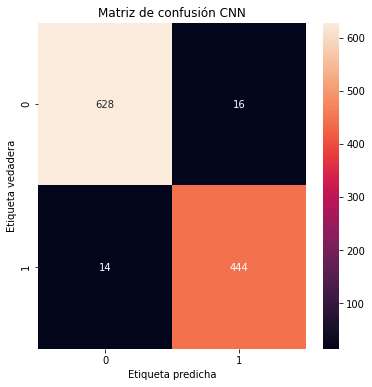

In [ ]:
plot_cm(test_true_labels, test_pred_labels)

# Plot Another Confution Matrix style.

[[628  16]
 [ 11 447]]


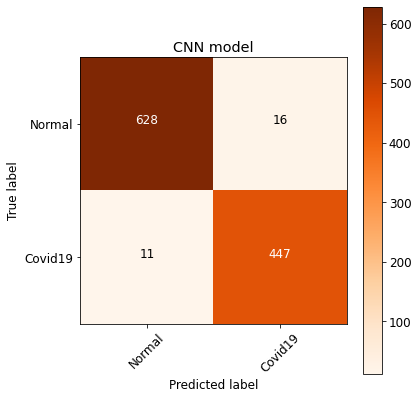

In [30]:
class_names=["Normal","Covid19"]
cm3 = confusion_matrix(test_true_labels, test_pred_labels > 0.5)
plot_confusion_matrix(cm3, classes=class_names)
                      

In [28]:
cm2 = confusion_matrix(test_true_labels,test_pred_labels > 0.5)
cm2

array([[628,  16],
       [ 11, 447]])

# TASK 8 : Compute metrics

In [ ]:
cmatrix = confusion_matrix(test_true_labels, test_pred_labels > 0.5)
TN = cmatrix[1][1]
print("TN: ", TN)
FP = cmatrix[0][1]
print("FP: ", FP)
FN = cmatrix[1][0]
print("FN: ", FN)
TP = cmatrix[0][0]
print("TP: ", TP)

print("******************************************************")
Accuracy = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy: ", Accuracy)
Sensitivity =  TP/(TP+FN)    
print("Sensitivity: ", Sensitivity)
Specificity = TN/(TN+FP)
print("Specificity: ", Specificity)



TN:  444
FP:  16
FN:  14
TP:  628
******************************************************
Accuracy:  0.9727767695099818
Sensitivity:  0.9781931464174455
Specificity:  0.9652173913043478


# TASK 8 : Plot ROC Curve

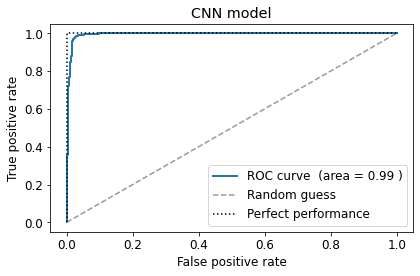

In [29]:
plot_roc(test_true_labels, test_pred_labels.ravel())


##TASK 8 : Prediction On New Data

In [ ]:
# from google.colab import files
# from keras.preprocessing import image
# filenames = files.upload()
# score = 0.0
# for filename in filenames.keys():
#   img = process_path_predict('/content/'+filename)
#   score = model.predict( tf.expand_dims(img, 0))
#   # if score > 0.5:
#   #   print('covid detected')
#   # else:
#   #   print('normal detected') 
#   print("This image is %.2f percent normal and %.2f percent covid" % (100 * (1 - score), 100 * score)) 